# HB KGL
_______

## Objective

This exercise is the resolution of the Kaggle problem [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/l).

To reformulate it, we will consider `cs-training.csv` dataset, remove the 1st column (index) and try to find the best algorithm to predict Column 2 `SeriousDlqin2yrs`, based on the other ones.

As `SeriousDlqin2yrs` has 2 values only, this is a classification problem. With the [scikit-learn](http://scikit-learn.org/) Python library we will apply different algorithms, and try to find the best one. As it becomes an optimization problem, we have to choose a measure to optimize: we'll use the **AUC (Area Under the Curve)**, applied on a subset and its complimentary of the original training dataset.
I think the challenge chose this metric because the **AUC** of the **ROC curve** is a perfect indicator for *binary classification*.
I chose of **AUC**, to fit with the the challenge, and also because it's quite easy to analyse the results by simply reading the curve. Also the implementation in *scikit-learn* is great.
About the alternative, we'll implement a **Confusion Matrix** based evaluation, but the results are not so easy to interpret, and improve. 

To determine the subsets and their complementaries, we'll use **Cross-Validation**

We're working on a pretty standard Data Science Stack: `Jupyter` + `Python3` + `Pandas` + `Matplotlib` + `sklearn`
Everything is virtualized behind *Docker* 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load dataset

In [4]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

## First try
We have a classification model, we try to predict the value (1 or 0) of `SeriousDlqin2yrs`.

In [5]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [6]:
X.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


To apply a model, we first need to fill the blanks in `MonthlyIncome` and `NumberOfDependents`. We will fill with medians

In [7]:
X.loc[X.MonthlyIncome.isnull(), 'MonthlyIncome'] = X.MonthlyIncome.median()
X.loc[X.NumberOfDependents.isnull(), 'NumberOfDependents'] = X.NumberOfDependents.median()

In [8]:
X.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


As a first approach, we try to use a logistic regression. As we want to evaluate this model, we choose to cross validate the model (https://en.wikipedia.org/wiki/Cross-validation_(statistics))

In [9]:
from sklearn.cross_validation import StratifiedKFold

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# CVNFOLDS = 7
# cv = StratifiedKFold(y, n_folds=CVNFOLDS)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [12]:
def eval_model(mod, X, y, CVNFOLDS=7):
    cv = StratifiedKFold(y, n_folds=CVNFOLDS)
    mem = []
    for i, (training, test) in enumerate(cv):
        fit = mod.fit(X.iloc[training], y.iloc[training])
        prob = fit.predict_proba(X.iloc[test])
        fpr, tpr, _ = roc_curve(y.iloc[test], prob[:, 1])
        a = auc(fpr, tpr)
        mem.append(a)
        print('ROC: %f' % a)
        plt.plot(fpr, tpr)
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    print("Mean: %f" % np.mean(mem))

ROC: 0.692877
ROC: 0.690494
ROC: 0.696284
ROC: 0.687494
ROC: 0.703366
ROC: 0.705614
ROC: 0.698438
Mean: 0.696367


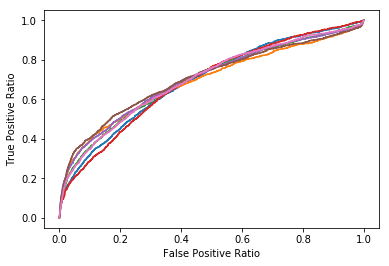

In [13]:
eval_model(LogisticRegression(), X, y)

Wich brings us at the position 830-ish... Could be better!
![leaderboard](https://www.dropbox.com/s/o5vleyi2rxywmle/Screenshot%202017-03-27%2011.16.11.png?dl=1)

**Let's try to clean a bit more our dataset**

## Analyse the set
**First we reload a fresh set**

In [14]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

### SeriousDlqin2yrs

In [15]:
from collections import Counter

In [16]:
Counter(data.SeriousDlqin2yrs)

Counter({0: 139974, 1: 10026})

### Age

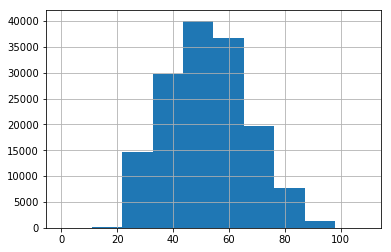

In [17]:
data.age.hist()

In [18]:
Counter(data[data.age<30].age)

Counter({0: 1,
         21: 183,
         22: 434,
         23: 641,
         24: 816,
         25: 953,
         26: 1193,
         27: 1338,
         28: 1560,
         29: 1702})

Only one `0`, this is probably a mistake, replacing by the median

In [19]:
data.loc[data.age < 21, 'age'] = data.age.median()

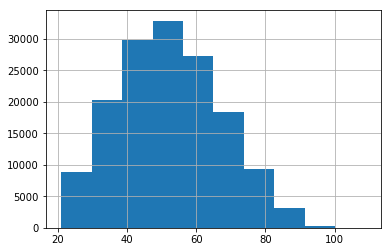

In [20]:
data.age.hist()

In [21]:
Counter(data[data.age>100].age)

Counter({101.0: 3, 102.0: 3, 103.0: 3, 105.0: 1, 107.0: 1, 109.0: 2})

### NumberOfTime3059DaysPastDueNotWorse

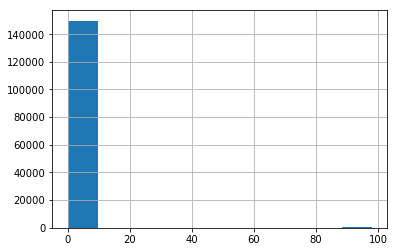

In [22]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

In [23]:
Counter(data["NumberOfTime30-59DaysPastDueNotWorse"])

Counter({0: 126018,
         1: 16033,
         2: 4598,
         3: 1754,
         4: 747,
         5: 342,
         6: 140,
         7: 54,
         8: 25,
         9: 12,
         10: 4,
         11: 1,
         12: 2,
         13: 1,
         96: 5,
         98: 264})

We assume 96 & 98 are mistakes

In [24]:
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

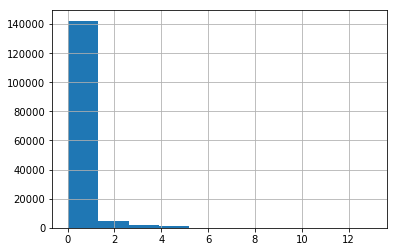

In [25]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

### NumberOfTimes90DaysLate

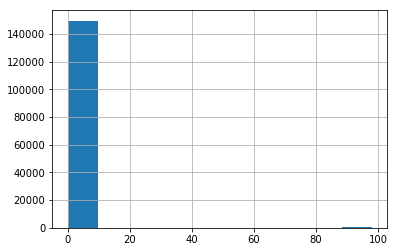

In [26]:
data.NumberOfTimes90DaysLate.hist()

In [27]:
Counter(data.NumberOfTimes90DaysLate)

Counter({0: 141662,
         1: 5243,
         2: 1555,
         3: 667,
         4: 291,
         5: 131,
         6: 80,
         7: 38,
         8: 21,
         9: 19,
         10: 8,
         11: 5,
         12: 2,
         13: 4,
         14: 2,
         15: 2,
         17: 1,
         96: 5,
         98: 264})

Same mistake ?

In [28]:
data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

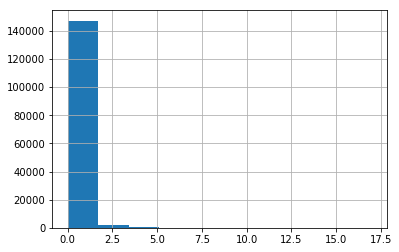

In [29]:
data.NumberOfTimes90DaysLate.hist()

### NumberRealEstateLoansOrLines

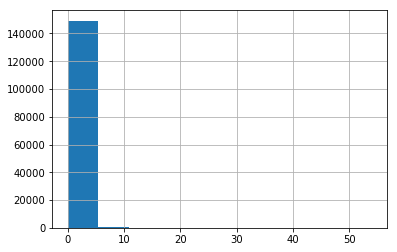

In [30]:
data.NumberRealEstateLoansOrLines.hist()

In [31]:
Counter(data.NumberRealEstateLoansOrLines)

Counter({0: 56188,
         1: 52338,
         2: 31522,
         3: 6300,
         4: 2170,
         5: 689,
         6: 320,
         7: 171,
         8: 93,
         9: 78,
         10: 37,
         11: 23,
         12: 18,
         13: 15,
         14: 7,
         15: 7,
         16: 4,
         17: 4,
         18: 2,
         19: 2,
         20: 2,
         21: 1,
         23: 2,
         25: 3,
         26: 1,
         29: 1,
         32: 1,
         54: 1})

It seems acceptable

### NumberOfDependents

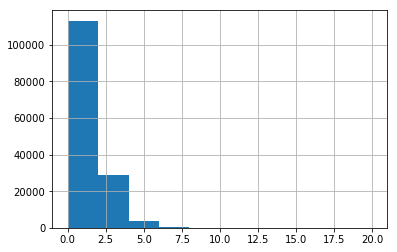

In [32]:
data.NumberOfDependents.hist()

In [33]:
# Counter(data.NumberOfDependents)

As done in the first section, let's remove the nulls

In [34]:
data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

In [35]:
Counter(data.NumberOfDependents)
# data.NumberOfDependents[data.NumberOfDependents.isnull()]

Counter({0.0: 90826,
         1.0: 26316,
         2.0: 19522,
         3.0: 9483,
         4.0: 2862,
         5.0: 746,
         6.0: 158,
         7.0: 51,
         8.0: 24,
         9.0: 5,
         10.0: 5,
         13.0: 1,
         20.0: 1})

More than 10 dependents is too rare

In [36]:
data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

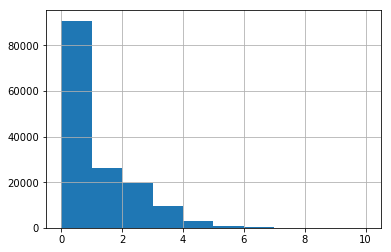

In [37]:
data.NumberOfDependents.hist()

### RevolvingUtilizationOfUnsecuredLines

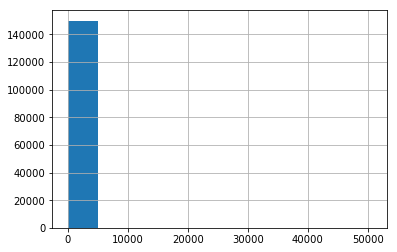

In [38]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

In [39]:
data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()

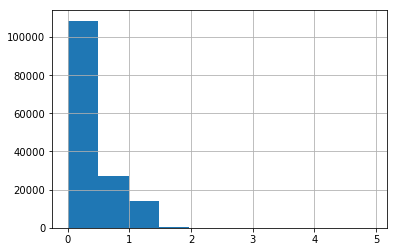

In [40]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

It seems acceptable

### DebtRatio

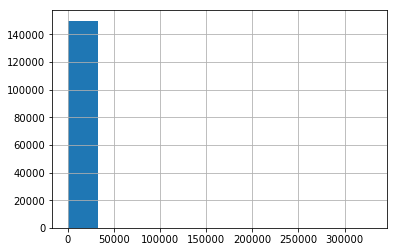

In [41]:
data.DebtRatio.hist()

In [42]:
# Counter(data.DebtRatio)

In [43]:
data.loc[
    data.DebtRatio > 5,
    'DebtRatio',
] = data.DebtRatio.median()

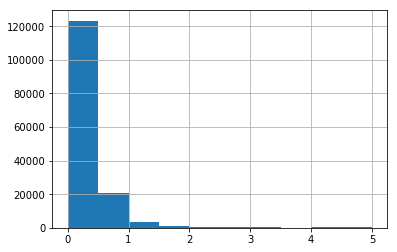

In [44]:
data.DebtRatio.hist()

In [45]:
data.DebtRatio.describe()

count    150000.000000
mean          0.371200
std           0.394357
min           0.000000
25%           0.175074
50%           0.366506
75%           0.414913
max           5.000000
Name: DebtRatio, dtype: float64

### MonthlyIncome

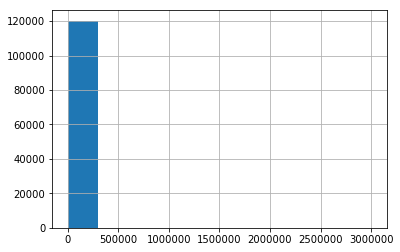

In [46]:
data.MonthlyIncome.hist()

In [47]:
data.MonthlyIncome.describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [48]:
data.loc[data.MonthlyIncome.isnull(), 'MonthlyIncome'] = data.MonthlyIncome.median()

In [49]:
data.MonthlyIncome.describe()

count    1.500000e+05
mean     6.418455e+03
std      1.289040e+04
min      0.000000e+00
25%      3.903000e+03
50%      5.400000e+03
75%      7.400000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

### NumberOfOpenCreditLinesAndLoans

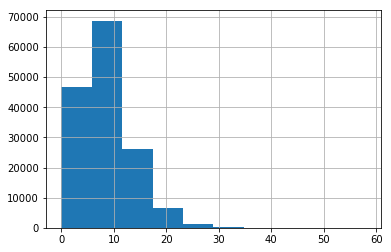

In [50]:
data.NumberOfOpenCreditLinesAndLoans.hist()

In [51]:
data.NumberOfOpenCreditLinesAndLoans.describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

It seems acceptable

### NumberOfTime60-89DaysPastDueNotWorse

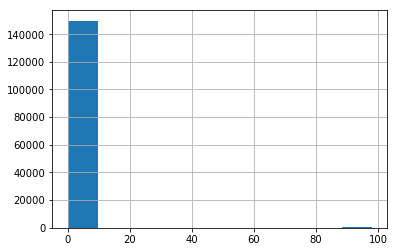

In [52]:
data["NumberOfTime60-89DaysPastDueNotWorse"].hist()

In [53]:
data["NumberOfTime60-89DaysPastDueNotWorse"].describe()

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

It seems acceptable

### Check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f011905ae10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0118c32f98>]], dtype=object)

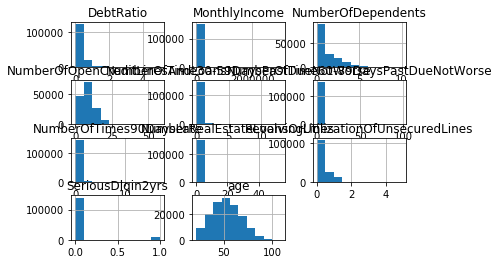

In [54]:
data.hist()

## Predictions
### Logistic regression

In [55]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

ROC: 0.834614
ROC: 0.807672
ROC: 0.804414
ROC: 0.839437
ROC: 0.846212
ROC: 0.826533
ROC: 0.852132
Mean: 0.830145


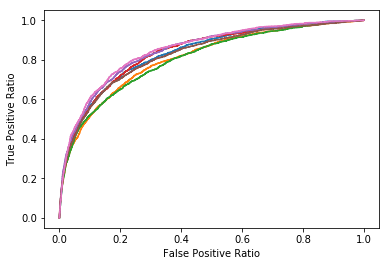

In [56]:
eval_model(LogisticRegression(), X, y)

**Position 575-ish**

ROC: 0.855108
ROC: 0.857138
ROC: 0.858318
ROC: 0.857415
ROC: 0.864138
ROC: 0.853770
ROC: 0.867405
Mean: 0.859042


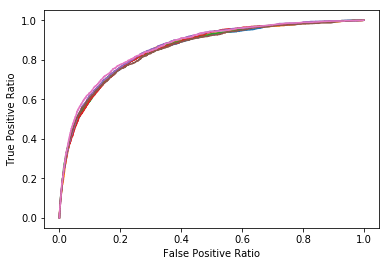

In [57]:
from sklearn.ensemble import AdaBoostClassifier
eval_model(AdaBoostClassifier(), X, y)

**Position 545-ish**

ROC: 0.778519
ROC: 0.781671
ROC: 0.777848
ROC: 0.779552
ROC: 0.790341
ROC: 0.785044
ROC: 0.781417
Mean: 0.782056


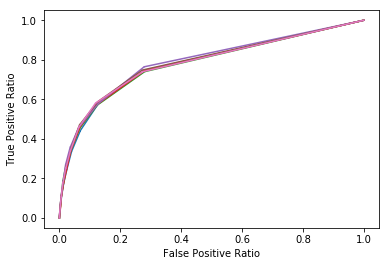

In [58]:
from sklearn.ensemble import RandomForestClassifier
eval_model(RandomForestClassifier(), X, y)

ROC: 0.859631
ROC: 0.862674
ROC: 0.862556
ROC: 0.862817
ROC: 0.867777
ROC: 0.859775
ROC: 0.873472
Mean: 0.864100


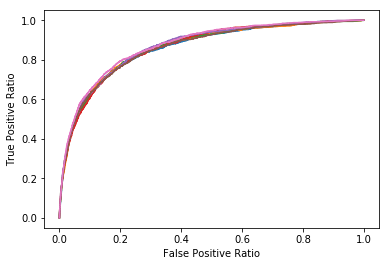

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
eval_model(GradientBoostingClassifier(), X, y)

**Position 410-ish**

ROC: 0.860829
ROC: 0.863749
ROC: 0.863133
ROC: 0.863564
ROC: 0.868994
ROC: 0.860140
ROC: 0.874353
Mean: 0.864966


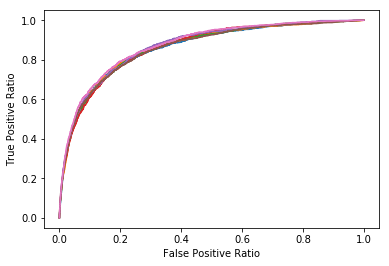

In [61]:
eval_model(GradientBoostingClassifier(
    loss='deviance',
    learning_rate=0.1,
    n_estimators=200,
    subsample=1.0,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    init=None,
    random_state=None,
    max_features=None,
    verbose=0,
), X, y)

By changing the parameters, we can reach **position 250-ish**

ROC: 0.810925
ROC: 0.836705
ROC: 0.628601
ROC: 0.813556
ROC: 0.694835
ROC: 0.669096
ROC: 0.778529
Mean: 0.747464


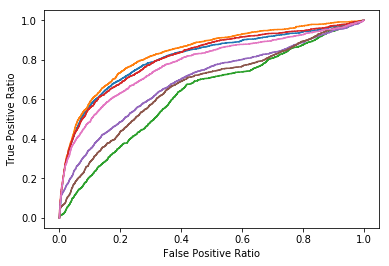

In [60]:
from sklearn.neural_network import MLPClassifier
eval_model(MLPClassifier(), X, y)

NN Classifier is not valid at all

## Alternative evaluation method: Confusion Matrix

In [62]:
from sklearn.metrics import confusion_matrix

In [63]:
def fits_probas_tests(mod, X, y, CVNFOLDS=3):
    cv = StratifiedKFold(y, n_folds=CVNFOLDS)
    tests = []
    probas = []
    fits = []

    for i, (training, test) in enumerate(cv):
        fit = mod.fit(X.iloc[training], y.iloc[training])
        fits.append(fit)
        probas.append(fit.predict_proba(X.iloc[test]))
        tests.append(y.iloc[test])
    return fits, probas, tests

In [64]:
def probas_2_bin(X):
    res = []
    for i, v in enumerate(X):
        if v > 0.5:
            res.append(1)
        else:
            res.append(0)
    return res

In [65]:
fit, probas, tests = fits_probas_tests(GradientBoostingClassifier(
    loss='deviance',
    learning_rate=0.1,
    n_estimators=200,
    subsample=1.0,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    init=None,
    random_state=None,
    max_features=None,
    verbose=0,
), X, y)

In [66]:
cm = confusion_matrix(tests[0], probas_2_bin(probas[0][:, 1]))
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

[[46157   501]
 [ 2678   664]]


## To go further

We reached quite easily the position 250-ish, but our data has been cleaned quickly. A more complete model would replace the `NA` using a predictive model (based on the other columns). I think it might be useful, especially for the incomes.

We should also be able to adjust the coefficient of the models with more precisions. I think we can only continue with Gradient Boosting Classifier, as it offers the best results.

